In [1]:
# Copyright 2022–2024 Richard Laugesen
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Mechanism behind the impact from risk aversion

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

from ruvpy.relative_utility_value import relative_utility_value
from ruvpy.damage_functions import logistic_zero
from ruvpy.economic_models import cost_loss, cost_loss_analytical_spend
from ruvpy.utility_functions import cara
from ruvpy.decision_rules import optimise_over_forecast_distribution

# Load example forecast dataset

In [41]:
# Steamflow at Biggara in the Murray catchment of the southern Murray-Darling basin
# Subseasonal streamflow forecasts from MuTHRE and event frequency for reference

# load and convert runoff to cumecs
data = pd.read_csv('example_data/401012-muthre.csv.zip', index_col=0, parse_dates=True, dayfirst=True, compression='zip')
data *= 1165 / 86.4

# filter to the first week of each month
data = data[(data.index.day >= 1) & (data.index.day <= 7)]

# fetch the obs and forecast ensemble
obs = data['obs']
fcst = data[[col for col in data.columns if col.startswith('ens-')]]

# RUV library expects numpy arrays
obs = obs.values
fcst = fcst.values

print(obs.shape, fcst.shape)

(1932,) (1932, 100)


# Define decision context

In [42]:
parallel_nodes = 2

alphas = [0.2]
decision_thresholds = np.arange(2, 225, 5)
risk_aversion_coefficients = [0, 0.3, 1, 5]

# note there is no utility function or decision thresholds defined, we will add these before calling relative_utility_value
decision_context = {
    'economic_model': [cost_loss, cost_loss_analytical_spend, alphas],
    'decision_rule': [optimise_over_forecast_distribution, None],
    'damage_function': [logistic_zero, {'A': 1, 'k': 0.07, 'threshold': np.nanquantile(obs, 0.99)}], # threshold defined later
}

ref = None  # tell RUV library to use obs to replicate event frequency reference as in REV

# Calculate RUV using different decision rules

In [43]:
results = xr.DataArray(np.nan, dims=('risk_aversion', 'decision_threshold', 'alpha'), coords={'risk_aversion': risk_aversion_coefficients, 'decision_threshold': decision_thresholds, 'alpha': alphas})

In [44]:
for risk_aversion in risk_aversion_coefficients:
    print('Calculating RUV for risk aversion %.1f' % risk_aversion)
    
    for decision_threshold in decision_thresholds:            
        decision_context['decision_thresholds'] = np.array([0, decision_threshold])
        decision_context['utility_function'] = [cara, {'A': risk_aversion}]
    
        for alpha in alphas:
            results.loc[{'risk_aversion': risk_aversion, 'decision_threshold': decision_threshold}] = relative_utility_value(obs, fcst, ref, decision_context, parallel_nodes)['ruv']

Calculating RUV for risk aversion 0.0
Calculating RUV for risk aversion 0.3
Calculating RUV for risk aversion 1.0
Calculating RUV for risk aversion 5.0


# Plot results on a value diagram

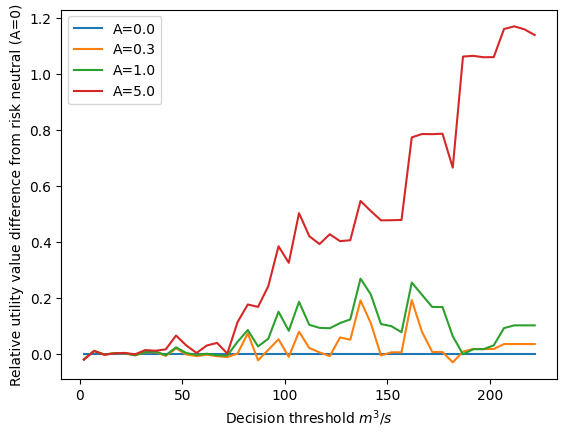

In [47]:
risk_aversion_coefficients = results.coords['risk_aversion'].values
decision_thresholds = results.coords['decision_threshold'].values
alphas = results.coords['alpha'].values

for i, alpha in enumerate(alphas):
    for risk_aversion in risk_aversion_coefficients:
        
        data = results.sel(risk_aversion=risk_aversion, alpha=alpha)
        data_risk_neutral = results.sel(risk_aversion=0, alpha=alpha)
        
        plt.plot(decision_thresholds, data.values - data_risk_neutral.values, label='A=%.1f' % risk_aversion)

    plt.xlabel(r'Decision threshold $m^3/s$')
    plt.ylabel(r'Relative utility value difference from risk neutral (A=0)')

    plt.legend()

plt.show()